# Waste classification Project
## Course: DSAI4101: Applied Deep Learning
## Section: 3/4

## Student ID: 60300294
## Student name: AlMoatasim Mohammad Taha


---------------------------------

### install all the needed libraries 

In [3]:
!pip install pandas numpy matplotlib scikit-learn 
!pip install torch torchvision

### import the libraries 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics  import f1_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms

from PIL import Image

print("All libraries imported successfully.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

All libraries imported successfully.
Using device: cpu


### Sample image from the dataset

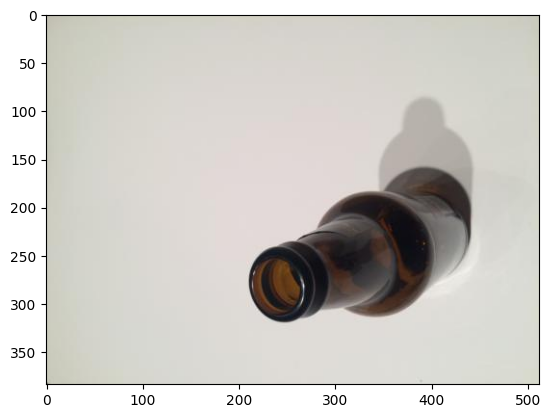

In [5]:
train_image = r"C:\Users\UDST\OneDrive - University of Doha for Science and Technology\Year 4\DSAI4101 - Deep Learning\project\data\train\glass\glass1.jpg"

image = Image.open(train_image)
plt.imshow(image)

In [ ]:
def load_dataset(image_size = 224, batch_size= 32):
    # path of the data (train-test)
    train_data = r"..\project\data\train"
    test_data = r"..\project\data\test"
    
    # transformations
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    
    # datasets
    train_dataset = datasets.ImageFolder(root=train_data, transform=train_transform)
    test_dataset = datasets.ImageFolder(root=test_data, transform=test_transform)
    
    # dataloaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    # classes 
    classes = train_dataset.classes
    
    return train_loader, test_loader, classes


In [7]:
train_loader, test_loader, classes = load_dataset()
print(f"the classes that we have in data: {classes}")

the classes that we have in data: ['glass', 'metal', 'paper', 'plastic']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6156863..0.96862745].


Class Index: 0
Class Name: glass


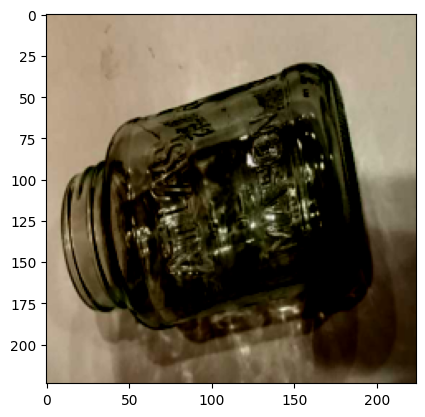

In [8]:
def show_sample(image, label, classes_name):
    print(f"Class Index: {label}")
    print(f"Class Name: {classes_name[label]}")
    plt.imshow(image.permute(1, 2, 0))
    #plt.axis('off')
    
# Get a sample from the training dataset
image, label = next(iter(train_loader))
show_sample(image[0], label[0], classes_name=classes)

In [9]:
# Get one batch to inspect tensor shapes
images, labels = next(iter(train_loader))

m_train = len(train_loader.dataset)
m_test = len(test_loader.dataset)

batch_shape = images.shape     # e.g., [32, 3, 224, 224]
single_image_shape = images[0].shape   # e.g., [3, 224, 224]

print("Dataset Summary:")
print(f"Number of training examples: {m_train}")
print(f"Number of testing examples : {m_test}")

print(f"Batch tensor shape: {batch_shape}")
print(f"Single image shape: {single_image_shape}")

print(f"Number of classes: {len(classes)}")
print(f"Class names: {classes}")


Dataset Summary:
Number of training examples: 1540
Number of testing examples : 100
Batch tensor shape: torch.Size([32, 3, 224, 224])
Single image shape: torch.Size([3, 224, 224])
Number of classes: 4
Class names: ['glass', 'metal', 'paper', 'plastic']


In [10]:
class WasteDNN(nn.Module):
    def __init__(self, image_size=224, num_classes=None):
        super(WasteDNN, self).__init__()
        
        # Determine number of classes
        if num_classes is None: 
            num_classes = len(classes)
        
        # After flattening the image
        in_features = 3 * image_size * image_size   # e.g., 3 × 224 × 224 = 150,528
        
        # Fully connected layers
        # Hidden layer 1
        self.fc1 = nn.Linear(in_features, 2048)
        self.bn1 = nn.BatchNorm1d(2048)
        
        # Hidden layer 2
        self.fc2 = nn.Linear(2048, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        
        # Hidden layer 3
        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)
        
        # Hidden layer 4
        self.fc4 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(256)
        
        # Output layer (layer 5)
        self.fc5 = nn.Linear(256, num_classes)

        # Dropout layer 
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        """
        Forward pass of the network:
        how the data flows through the network layers.
        """
        # Flatten the image to 1 long vector
        x = x.view(x.size(0), -1)  
        
        # Layer 1: FC → BN → ReLU → Dropout
        x = F.relu(self.bn1(self.fc1(x))) 
        x = self.dropout(x)
        
        # Layer 2: FC → BN → ReLU → Dropout
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        
        # Layer 3: FC → BN → ReLU → Dropout
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        
        # Layer 4: FC → BN → ReLU → Dropout
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        
        # Layer 5 (output): logits only (no BN, no ReLU, no Dropout)
        x = self.fc5(x)
        return x
    
# Instantiate the model
model = WasteDNN(image_size=224, num_classes=len(classes)).to(device)
print(model)


WasteDNN(
  (fc1): Linear(in_features=150528, out_features=2048, bias=True)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [11]:
def setup_training(model, learning_rate=1e-3, num_epochs=15):
    """
    Creates and returns:
    - optimizer
    - loss function (criterion)
    - number of epochs
    """
    # Loss function for multi-class classification
    criterion = nn.CrossEntropyLoss()

    # Adam optimizer with given LR
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("Training setup complete:")
    print(f"→ Number of epochs : {num_epochs}")
    print(f"→ Learning rate    : {learning_rate}")
    print(f"→ Loss function    : CrossEntropyLoss")
    print(f"→ Optimizer        : Adam")

    return criterion, optimizer, num_epochs


# Call the setup function
criterion, optimizer, num_epochs = setup_training(model, learning_rate=1e-3, num_epochs=20)



Training setup complete:
→ Number of epochs : 20
→ Learning rate    : 0.001
→ Loss function    : CrossEntropyLoss
→ Optimizer        : Adam


In [12]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    """
    Train the model and evaluate on validation using F1-score.
    """

    train_losses, val_losses = [], []
    train_f1_scores, val_f1_scores = [], []

    for epoch in range(num_epochs):
        # ---------- TRAIN ----------
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            # collect preds for F1 score
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # compute train metrics
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_f1 = f1_score(all_labels, all_preds, average='macro')

        train_losses.append(epoch_train_loss)
        train_f1_scores.append(epoch_train_f1)

        # ---------- VALIDATION ----------
        model.eval()
        running_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # compute val metrics
        epoch_val_loss = running_loss / len(test_loader.dataset)
        epoch_val_f1 = f1_score(all_labels, all_preds, average='macro')

        val_losses.append(epoch_val_loss)
        val_f1_scores.append(epoch_val_f1)

        print(f"Epoch [{epoch+1}/{num_epochs}]  "
              f"Train Loss: {epoch_train_loss:.4f} | Train F1: {epoch_train_f1:.4f}  "
              f"| Val Loss: {epoch_val_loss:.4f} | Val F1: {epoch_val_f1:.4f}")

    return train_losses, val_losses, train_f1_scores, val_f1_scores


In [13]:
train_losses, val_losses, train_f1_scores, val_f1_scores = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)


Epoch [1/20]  Train Loss: 1.2643 | Train F1: 0.4472  | Val Loss: 1.1026 | Val F1: 0.5421
Epoch [2/20]  Train Loss: 1.1525 | Train F1: 0.5050  | Val Loss: 1.0826 | Val F1: 0.5286
Epoch [3/20]  Train Loss: 1.1134 | Train F1: 0.5179  | Val Loss: 1.0437 | Val F1: 0.6250
Epoch [4/20]  Train Loss: 1.0398 | Train F1: 0.5645  | Val Loss: 0.9581 | Val F1: 0.5998
Epoch [5/20]  Train Loss: 1.0134 | Train F1: 0.5712  | Val Loss: 0.9696 | Val F1: 0.6312
Epoch [6/20]  Train Loss: 0.9389 | Train F1: 0.6154  | Val Loss: 0.9948 | Val F1: 0.5995
Epoch [7/20]  Train Loss: 0.8757 | Train F1: 0.6460  | Val Loss: 1.0733 | Val F1: 0.5385
Epoch [8/20]  Train Loss: 0.8433 | Train F1: 0.6601  | Val Loss: 0.8787 | Val F1: 0.6160
Epoch [9/20]  Train Loss: 0.7978 | Train F1: 0.6730  | Val Loss: 0.9015 | Val F1: 0.6268
Epoch [10/20]  Train Loss: 0.7883 | Train F1: 0.6797  | Val Loss: 0.8944 | Val F1: 0.6101
Epoch [11/20]  Train Loss: 0.7308 | Train F1: 0.7192  | Val Loss: 0.8437 | Val F1: 0.6591
Epoch [12/20]  Trai

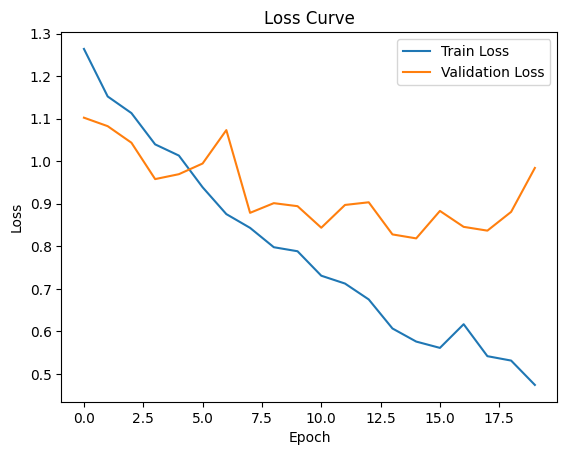

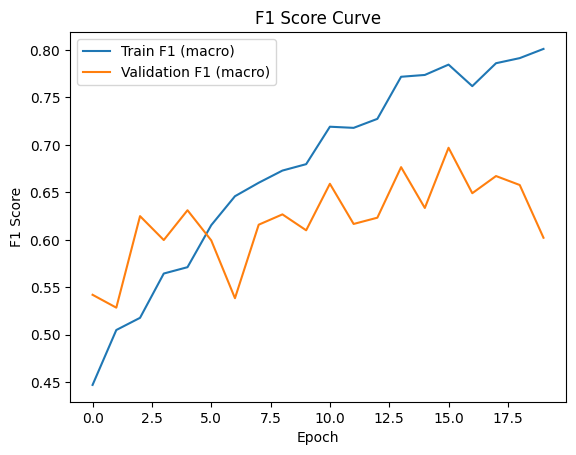

In [14]:
# Loss curves
# train/val loss
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

# F1-score curves
# train/val f1-score 
plt.figure()
plt.plot(train_f1_scores, label="Train F1 (macro)")
plt.plot(val_f1_scores, label="Validation F1 (macro)")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score Curve")
plt.legend()
plt.show()



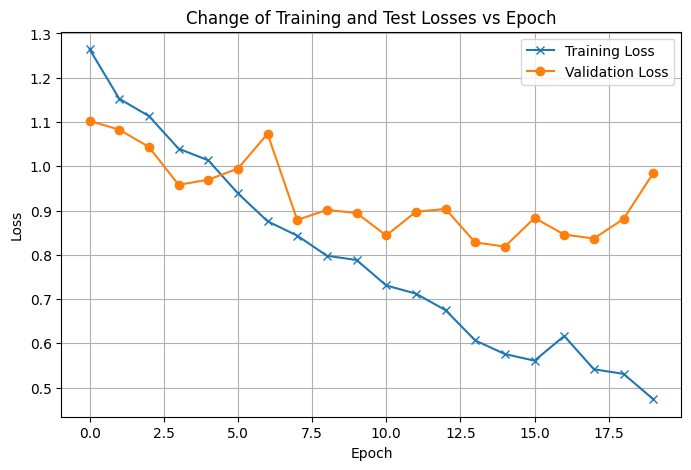

In [21]:
# Plot Training Loss and Validation (Test) Loss vs Epoch

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", marker='x')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Change of Training and Test Losses vs Epoch")
plt.legend()
plt.grid(True)
plt.show()


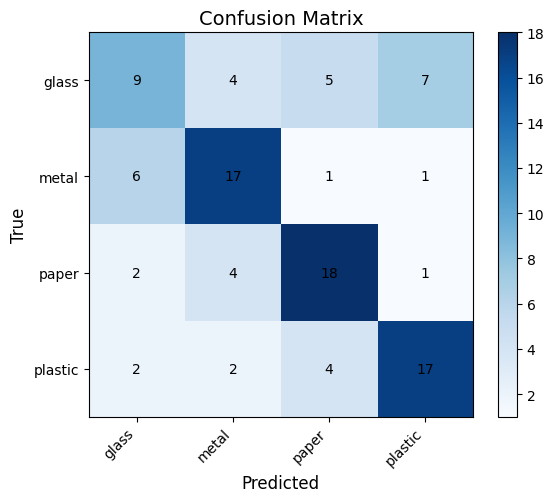


Classification Report:
              precision    recall  f1-score   support

       glass       0.47      0.36      0.41        25
       metal       0.63      0.68      0.65        25
       paper       0.64      0.72      0.68        25
     plastic       0.65      0.68      0.67        25

    accuracy                           0.61       100
   macro avg       0.60      0.61      0.60       100
weighted avg       0.60      0.61      0.60       100



In [15]:
def evaluate_model(model, test_loader, classes, device):
    """
    Evaluates the model on the test dataset.
    Prints:
        - Classification Report (precision, recall, F1)
        - Confusion Matrix
    """
    
    model.eval()   # evaluation mode (no dropout)
    all_preds = []
    all_labels = []

    with torch.no_grad():   # no gradient calculation needed
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Build confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 5))
    cax = ax.imshow(cm, cmap="Blues")

    # Add color bar
    plt.colorbar(cax)

    # Axis labels
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.set_yticklabels(classes)

    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("True", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)

    # Add numbers inside squares
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, cm[i, j],
                    ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))


# Call the function
evaluate_model(model, test_loader, classes, device)

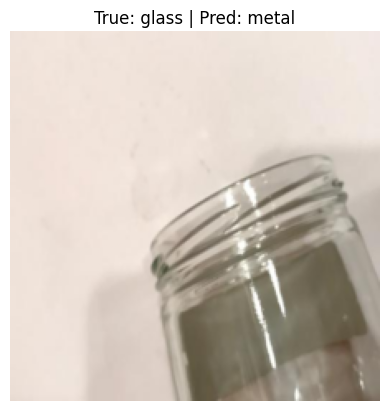

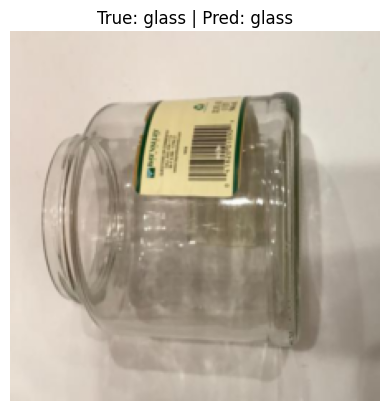

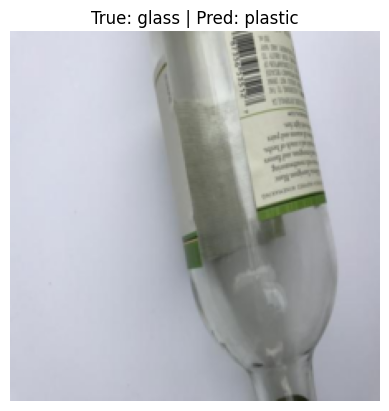

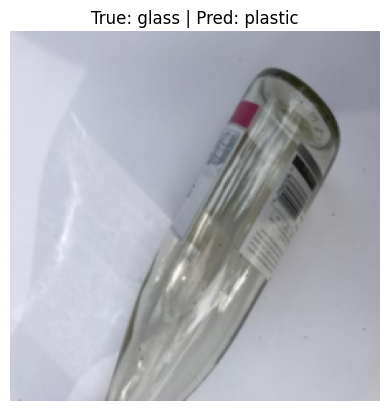

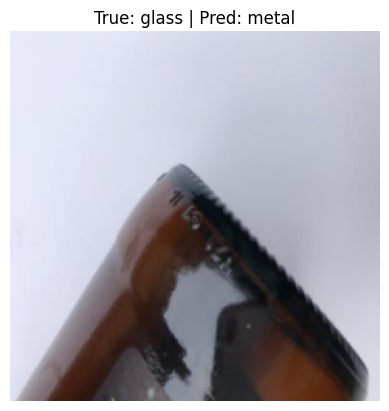

In [16]:
def show_prediction(model, loader, classes, device, n=5):
    model.eval()
    images, labels = next(iter(loader))

    for i in range(n):
        img = images[i].to(device)
        true_label = labels[i].item()

        with torch.no_grad():
            output = model(img.unsqueeze(0))
            _, pred = torch.max(output, 1)
            pred_label = pred.item()

        img_disp = images[i] * 0.5 + 0.5  # undo normalization
        plt.imshow(img_disp.permute(1, 2, 0))
        plt.title(f"True: {classes[true_label]} | Pred: {classes[pred_label]}")
        plt.axis("off")
        plt.show()

show_prediction(model, test_loader, classes, device, n=5)


In [17]:
import os
from PIL import Image

def predict_folder(model, folder_path, classes, device):
    """
    Predicts all images inside a folder.
    Shows each image + predicted class.
    """

    # SAME transform used in your DataLoader
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    # Loop over every file in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif")):

            img_path = os.path.join(folder_path, filename)

            # Load and preprocess image
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(device)

            # Predict
            model.eval()
            with torch.no_grad():
                outputs = model(img_tensor)
                _, predicted = torch.max(outputs, 1)
                class_name = classes[predicted.item()]

            # Show result
            plt.imshow(img)
            plt.title(f"{filename} → Predicted: {class_name}")
            plt.axis("off")
            plt.show()

            print(f"{filename} → Predicted class: {class_name}")


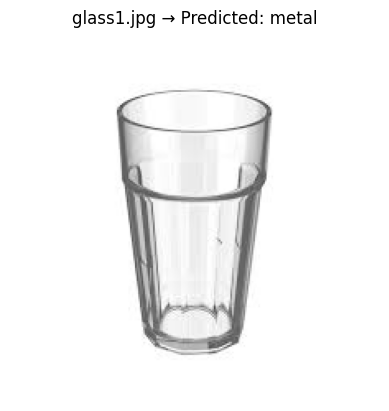

glass1.jpg → Predicted class: metal


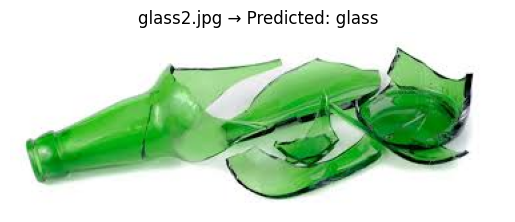

glass2.jpg → Predicted class: glass


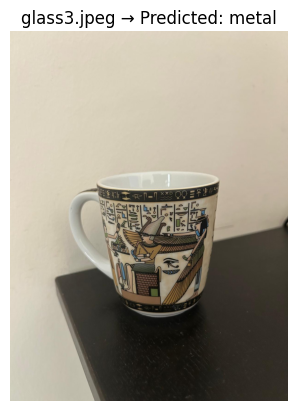

glass3.jpeg → Predicted class: metal


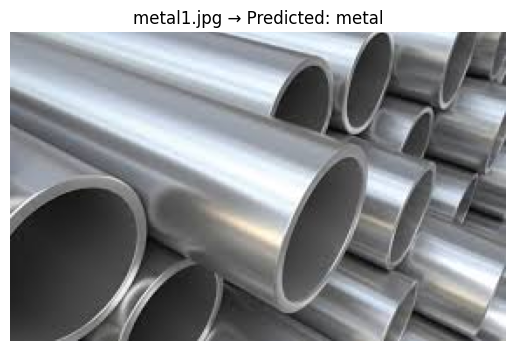

metal1.jpg → Predicted class: metal


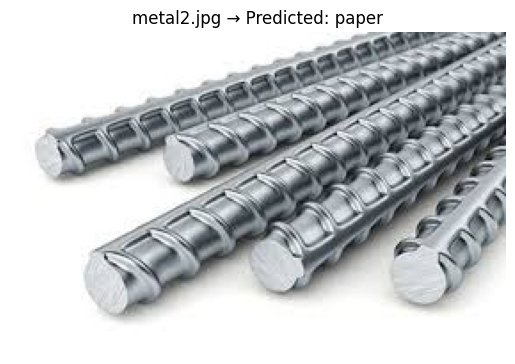

metal2.jpg → Predicted class: paper


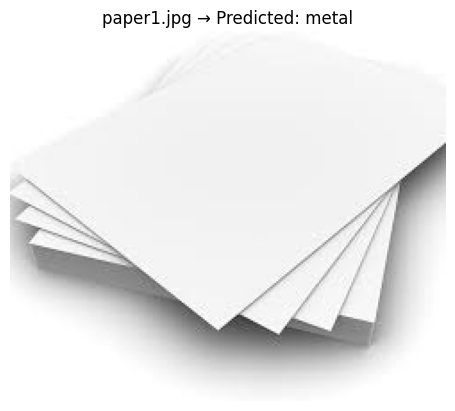

paper1.jpg → Predicted class: metal


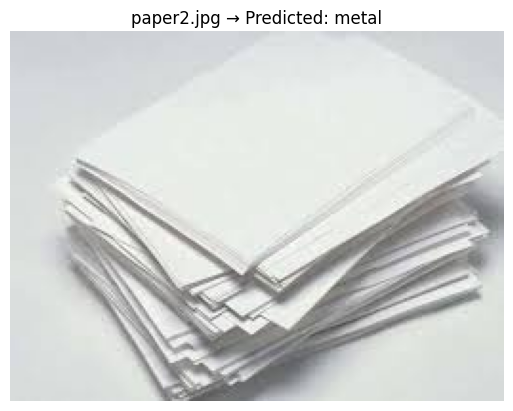

paper2.jpg → Predicted class: metal


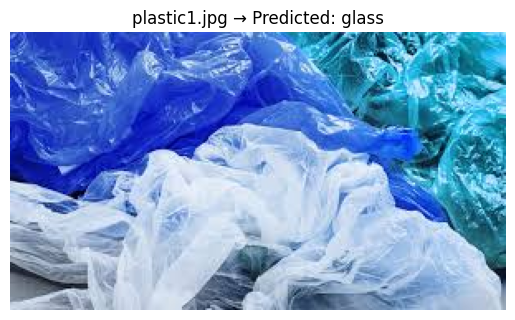

plastic1.jpg → Predicted class: glass


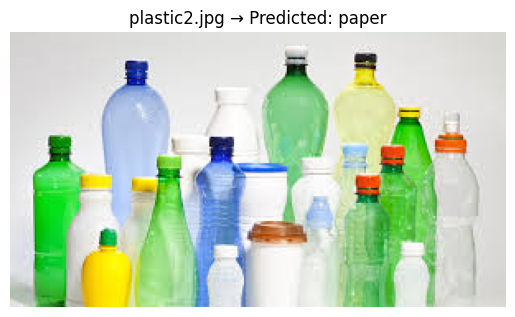

plastic2.jpg → Predicted class: paper


In [22]:
predict_folder(
    model,
    folder_path=r"..\project\image_from_internet",
    classes=classes,
    device=device
)
